In [53]:
import sys

sys.path.append("../")

In [54]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'

In [55]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'DOT', 'LUNA', 'UNI', 'LINK', 'BCH', 'LTC', 'ICP']
symbols = [f'{s}-USDT' for s in symbols]

data = []
start_date = '2021-06-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        print(file)
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[df.index > start_date][symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/BTC-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/ETH-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/ADA-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/BNB-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/SOL-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/XRP-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/DOGE-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/DOT-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/LUNA-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/UNI-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/LINK-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/BCH-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/LTC-USDT.csv
/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min/IC

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOGE-USDT,DOT-USDT,LUNA-USDT,UNI-USDT,LINK-USDT,BCH-USDT,LTC-USDT,ICP-USDT
open_time,,,,,,,,,,,,,,
2021-08-30 00:40:00,10.790625,8.073004,1.054660,6.166887,4.567053,0.128569,-1.275827,3.240637,3.512142,3.280911,3.239071,6.485398,5.156754,4.260141
2021-08-30 00:45:00,10.787473,8.067052,1.048722,6.162051,4.554403,0.123721,-1.279775,3.230804,3.504055,3.274121,3.234355,6.484177,5.152713,4.244917
2021-08-30 00:50:00,10.787636,8.067381,1.046266,6.159729,4.563723,0.121864,-1.278337,3.230014,3.504055,3.273364,3.231200,6.482801,5.149817,4.248352
2021-08-30 00:55:00,10.787255,8.067942,1.047670,6.159729,4.572957,0.123279,-1.278337,3.231989,3.507058,3.271848,3.233567,6.483413,5.150977,4.250208
2021-08-30 01:00:00,10.787828,8.067924,1.048371,6.160363,4.579442,0.124074,-1.276543,3.233173,3.520461,3.275256,3.235536,6.484024,5.152135,4.259294


In [56]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    # print("trace_crit_value",trace_crit_value)
    # print("eigen_crit_value",eigen_crit_value)
    # print("lr1",result.lr1)
    # print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [57]:

import itertools as it

cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, 3))
print(len(pairs))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except KeyError:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

364


,hedge_ratio,sid_1,sid_2,sid_3
0,"[12.773067746838853, -7.673780093957902, -13.4...",DOT-USDT,LINK-USDT,BCH-USDT
1,"[14.470525773564592, -8.85289093239732, -14.96...",DOT-USDT,LINK-USDT,LTC-USDT


In [58]:
coint_df.to_csv('coint_df.csv')

In [59]:
hedge_ratio = coint_df.iloc[0]['hedge_ratio']
hedge_ratio

array([ 12.77306775,  -7.67378009, -13.42090259])

In [61]:
s1 = df[coint_df['sid_1'].iloc[0]]
s2 = df[coint_df['sid_2'].iloc[0]]
s3 = df[coint_df['sid_3'].iloc[0]]

spread = s1*hedge_ratio[0] + s2*hedge_ratio[1] + s3*hedge_ratio[2]
spread

open_time
2021-06-01 00:05:00   -74.473227
2021-06-01 00:10:00   -74.424054
2021-06-01 00:15:00   -74.374802
2021-06-01 00:20:00   -74.413683
2021-06-01 00:25:00   -74.440635
                         ...    
2021-08-30 00:40:00   -70.502934
2021-08-30 00:45:00   -70.575958
2021-08-30 00:50:00   -70.543380
2021-08-30 00:55:00   -70.544520
2021-08-30 01:00:00   -70.552714
Length: 25498, dtype: float64

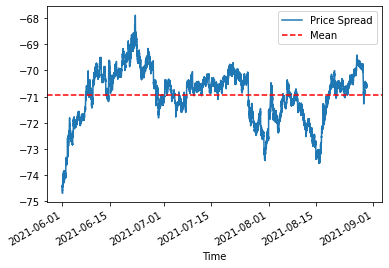

In [62]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [63]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

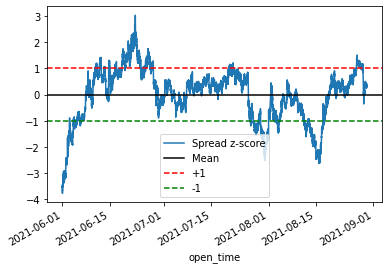

In [64]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])